# Exploratory data analysis - Watt wise project

In this notebook, we will:
1. Load and inspect the dataset.
2. Perform data integrity checks and preprocessing.
3. Explore time series characteristics and visualize key trends.
4. Prepare the data for modeling.

Modeling input / output: 
- Output (independent variable): building energy consumption 
- Inputs (dependent variables):  temperature, humidity, occupancy, and operational elements like HVAC and lighting usage.

# Libraries

In [58]:
# System & Data Handling
import os
import shutil
import pickle

# Data Loading
import kagglehub
import pandas as pd

# Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import calendar

# Time Series Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Constants
FIGSIZE = (16, 5)
FIGSIZE_LONG=(20, 6)

# Extracting and Loading the Data

In [59]:
# Download latest version
path = kagglehub.dataset_download("mrsimple07/energy-consumption-prediction")

print("Path to dataset files:", path)

file = os.listdir(path)[0]
file_path = os.path.join(path, file)
# copy the file to data folder
shutil.copy(file_path, "../data/data.csv")

df_data = pd.read_csv("../data/data.csv")
df_data.head()

Path to dataset files: /Users/bobhosseini/.cache/kagglehub/datasets/mrsimple07/energy-consumption-prediction/versions/1


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [60]:
# check the data shape, null values, and column types
print("data shape: ", df_data.shape)
print(df_data.info())

data shape:  (1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB
None


# Null values

In [61]:
# check if any column has null values
if df_data.isnull().sum().any():
    print("null values: ", df_data.isnull().sum())
else:
    print("no null values")

no null values


# Timestamp column

In [62]:
# convert the timestamp to datetime
print(df_data['Timestamp'].dtype)
df_data['Timestamp'] = pd.to_datetime(df_data['Timestamp'])
print(df_data['Timestamp'].dtype)

df_data.sort_values(by='Timestamp', ascending=True, inplace=True)
df_data.head()



object
datetime64[ns]


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


## Adding date and time

In [63]:
# create date and time columns
df_data['Date'] = df_data['Timestamp'].dt.date
df_data['Time'] = df_data['Timestamp'].dt.hour
df_data.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Date,Time
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,2022-01-01,0
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,2022-01-01,1
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2022-01-01,2
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,2022-01-01,3
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,2022-01-01,4


## Categorical columns' values

In [64]:
cat_cols = df_data.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['Date', 'Time']]
num_cols = df_data.select_dtypes(include=['int64', 'float64']).columns

print(cat_cols)
print(num_cols)



['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']
Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'RenewableEnergy', 'EnergyConsumption'],
      dtype='object')


In [65]:
for col in cat_cols:
    print(f"Unique values in {col}: {df_data[col].unique()}")
    print(f"Value counts in {col}:")
    print(df_data[col].value_counts())
    print("\n")



Unique values in HVACUsage: ['On' 'Off']
Value counts in HVACUsage:
HVACUsage
Off    508
On     492
Name: count, dtype: int64


Unique values in LightingUsage: ['Off' 'On']
Value counts in LightingUsage:
LightingUsage
Off    509
On     491
Name: count, dtype: int64


Unique values in DayOfWeek: ['Monday' 'Saturday' 'Sunday' 'Wednesday' 'Friday' 'Thursday' 'Tuesday']
Value counts in DayOfWeek:
DayOfWeek
Friday       164
Sunday       154
Thursday     146
Tuesday      146
Saturday     143
Wednesday    124
Monday       123
Name: count, dtype: int64


Unique values in Holiday: ['No' 'Yes']
Value counts in Holiday:
Holiday
No     533
Yes    467
Name: count, dtype: int64




### Weekday issues
Not balanced regarding number of weekdays

In [66]:
df_data['DayOfWeek'].value_counts()

DayOfWeek
Friday       164
Sunday       154
Thursday     146
Tuesday      146
Saturday     143
Wednesday    124
Monday       123
Name: count, dtype: int64

In [67]:
# Extract the day of the week from the timestamp

df_data['DayOfWeek_ext'] = df_data['Timestamp'].dt.day_name()
df_data['DayOfWeek_ext'].value_counts()

DayOfWeek_ext
Saturday     144
Sunday       144
Monday       144
Tuesday      144
Wednesday    144
Thursday     144
Friday       136
Name: count, dtype: int64

## Numerical columns

In [68]:
# statistical summary of the numeric columns
df_data.describe()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption,Time
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2022-01-21 19:29:59.999999744,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873,11.436000
min,2022-01-01 00:00:00,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278,0.000000
25%,2022-01-11 09:45:00,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690,5.000000
50%,2022-01-21 19:30:00,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696,11.000000
75%,2022-02-01 05:15:00,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742,17.000000
max,2022-02-11 15:00:00,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120,23.000000
std,NaN,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112,6.913009


# Missing time stamps or duplicates

In [69]:
df_data.set_index('Timestamp', inplace=True)
df_data.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Date,Time,DayOfWeek_ext
Timestamp,,,,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,2022-01-01,0,Saturday
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,2022-01-01,1,Saturday
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2022-01-01,2,Saturday
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,2022-01-01,3,Saturday
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,2022-01-01,4,Saturday


In [70]:
full_time_range = pd.date_range(start=df_data.index.min(), end=df_data.index.max(), freq='h')  # Assuming hourly data
missing_timestamps = full_time_range.difference(df_data.index)
# full_time_range
print("Missing timestamps:", missing_timestamps)
print("Total missing rows:", len(missing_timestamps))

Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='h')
Total missing rows: 0


## The start and end days' completness

In [71]:
# the first and the last timestamps
print(f"The start date and time: {df_data.index.min()}")
print(f"The end date and time: {df_data.index.max()}")

# drop last day from df_data as it's not complete
df_data_24h_complete = df_data[df_data['Date'] != df_data['Date'].max()].copy()

print(f"The correct end date and time: {df_data_24h_complete.index.max()}")

The start date and time: 2022-01-01 00:00:00
The end date and time: 2022-02-11 15:00:00
The correct end date and time: 2022-02-10 23:00:00


# Data Visualization

## Hourly Energy consumption

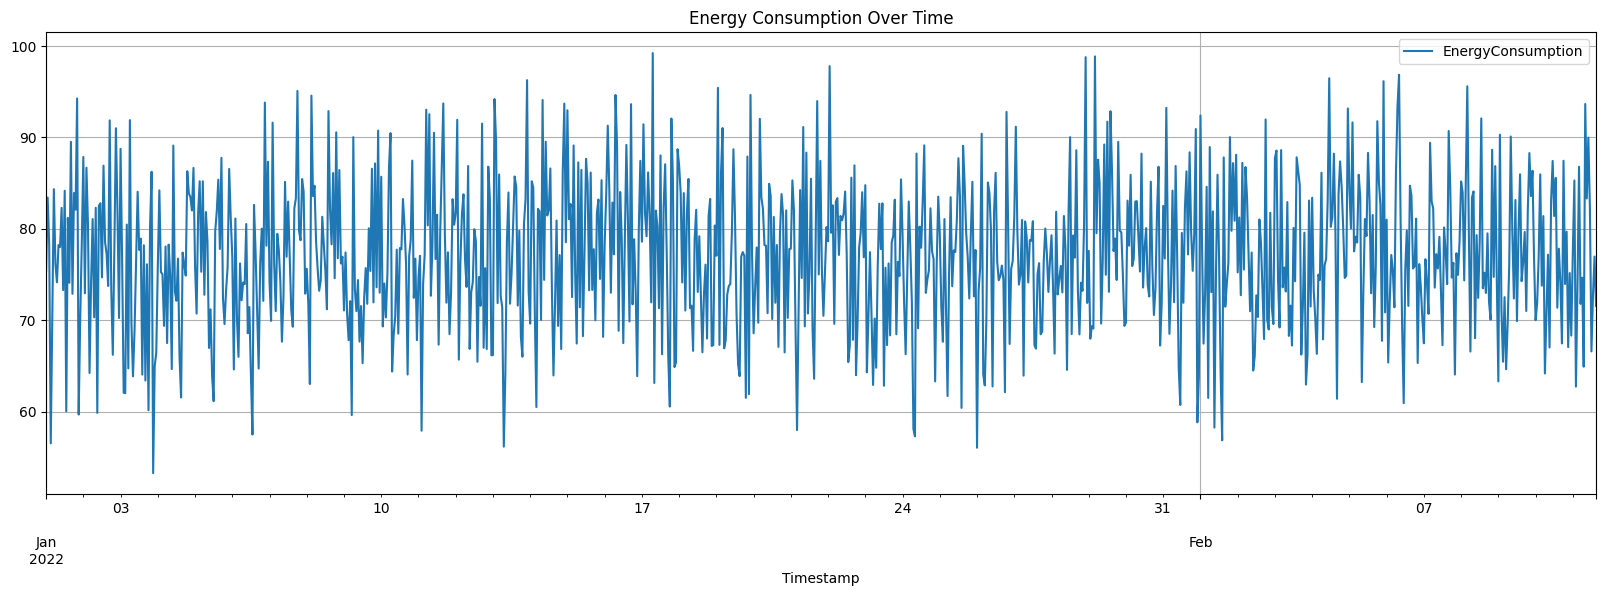

In [72]:
# line plot of the energy consumption

# plt.figure(figsize=(20, 6))
df_data.plot(kind='line', y='EnergyConsumption', figsize=FIGSIZE_LONG, title='Energy Consumption Over Time', grid=True)
# sns.lineplot(x='Timestamp', y='EnergyConsumption', data=df_data)
plt.show()



### Smoothed curve of hourly evergy consuption:
This plot shows the trend of energy consumption over time.
We see fluctiations, but we do not observe any general upraising or falling trend over time.

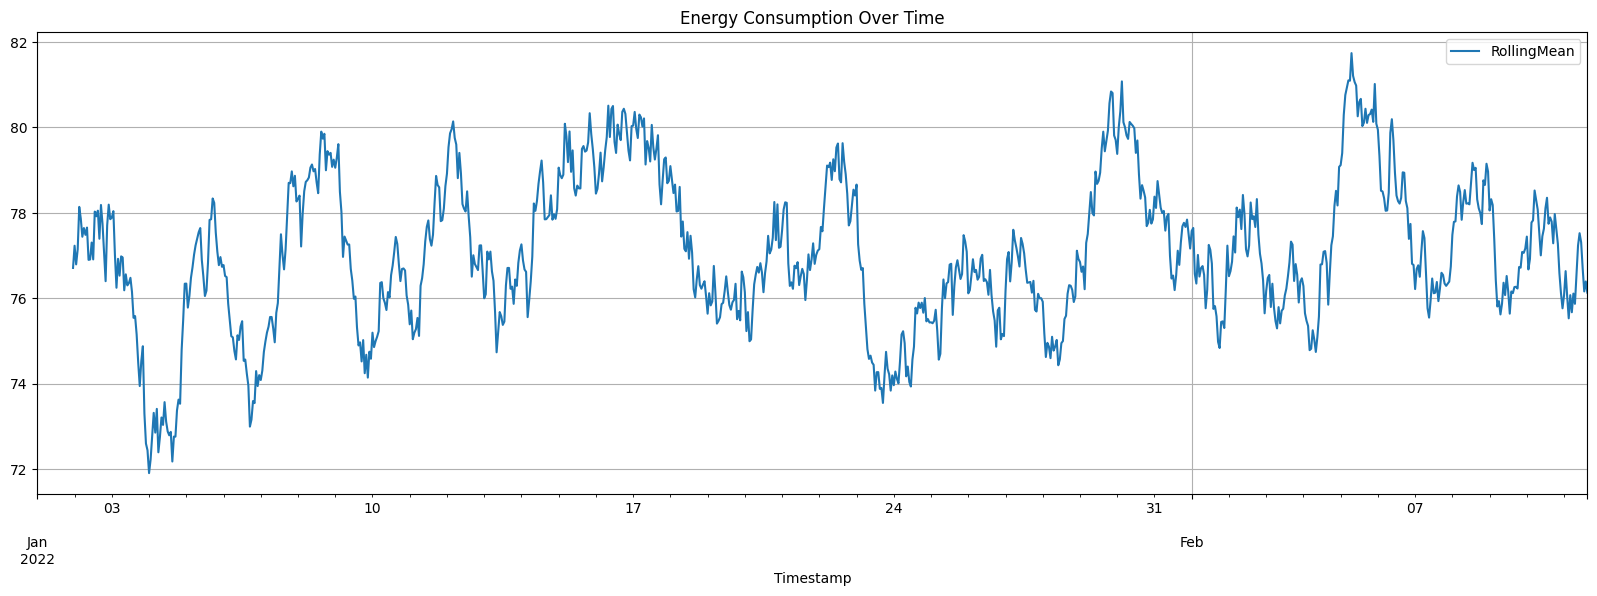

In [73]:
# Rolling window of data for each 24 samples
df_data['RollingMean'] = df_data['EnergyConsumption'].rolling(window=24).mean()
# Plot
df_data.plot(kind='line', y='RollingMean', figsize=FIGSIZE_LONG, title='Energy Consumption Over Time', grid=True)
plt.show()


### Comparing hourly consumption patterns

The following plot shows evergy consumption over a few consecutive days.
The overlaid plot doesn't show a consistent pattern accross them


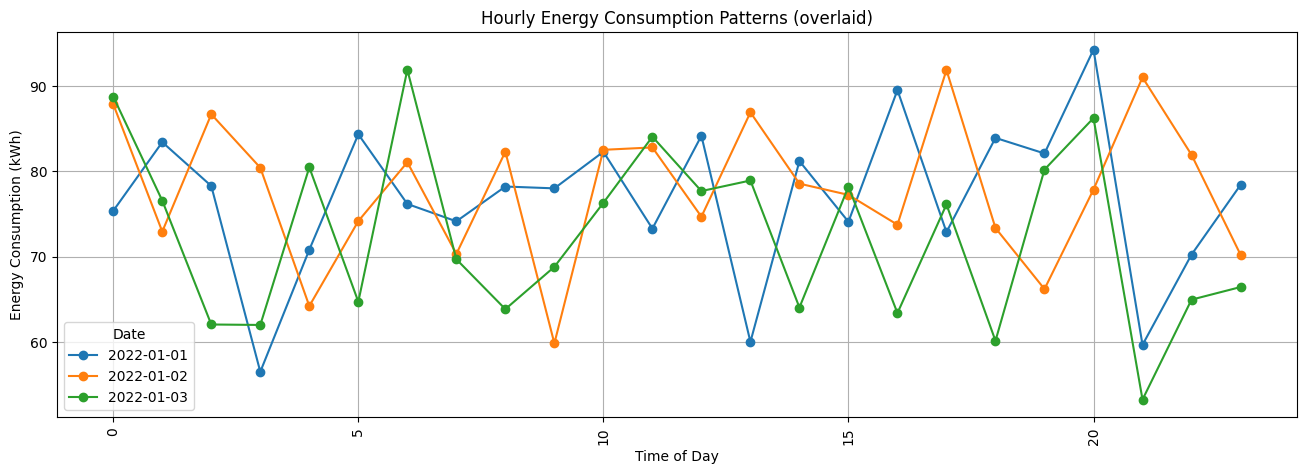

In [74]:
# Build a helper DataFrame
tmp = df_data.loc[:'2022-01-03', ['EnergyConsumption','Time', 'Date']].reset_index()
tmp['TimeStr'] = tmp['Timestamp'].dt.strftime('%H:%M')  # e.g. '14:00'
tmp['Date']    = tmp['Timestamp'].dt.date

# Pivot so each column is one day, indexed by the time‐strings
pivot = tmp.pivot(index='Time', columns='Date', values='EnergyConsumption')

# Plot
plt.figure(figsize = FIGSIZE)
pivot.plot(marker='o', ax=plt.gca())
plt.xlabel('Time of Day')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Hourly Energy Consumption Patterns (overlaid)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### Average hourly consumption:

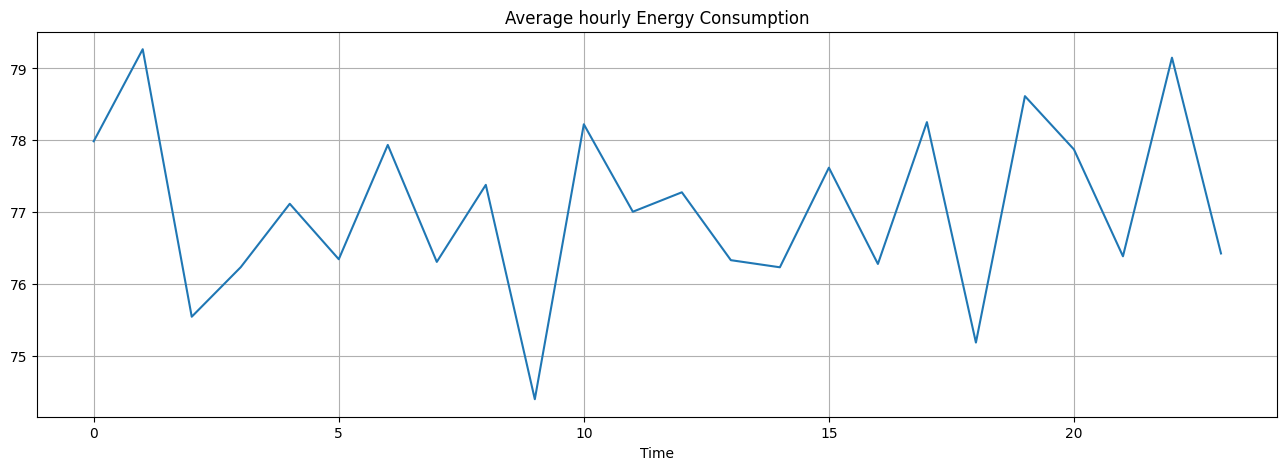

In [75]:
df_data_ave_hourly = df_data.groupby('Time')['EnergyConsumption'].mean()
df_data_ave_hourly.head()

df_data_ave_hourly.plot(kind='line', y='EnergyConsumption', figsize=FIGSIZE, title='Average hourly Energy Consumption', grid=True)
plt.show()

### Variation in hourly Energy consumption accross data

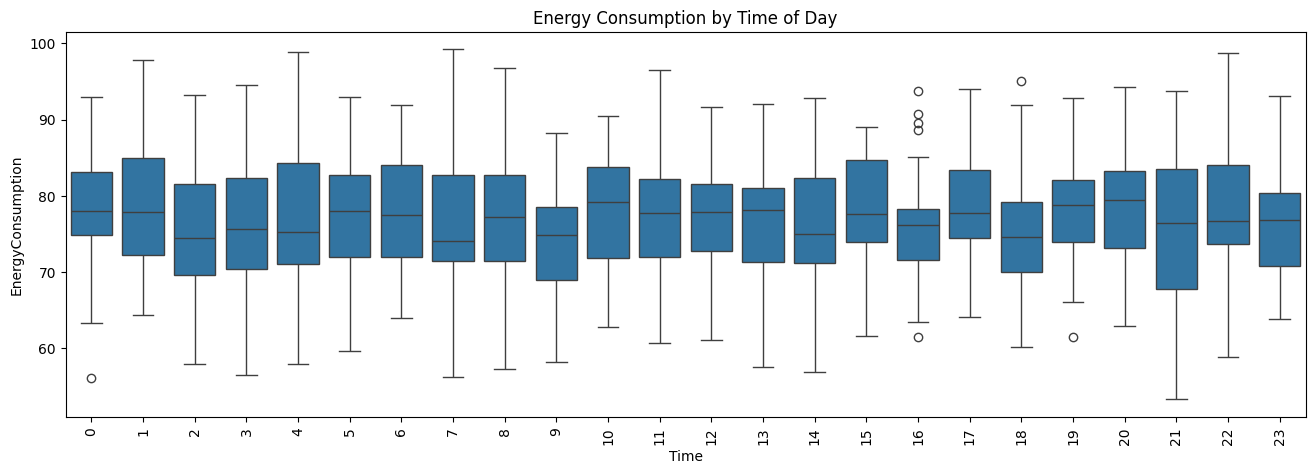

In [76]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(x='Time', y='EnergyConsumption', data=df_data)
plt.xticks(rotation=90)
plt.title('Energy Consumption by Time of Day')
plt.show()

### Average Hourly Consumption by Weekday

Averaging hourly consumption over different weekdays shows that some days have similar patterns in some windows during the day.

For example: 
- Mondays and Saturdays are similar in the first 5 hours of the day.
- Wednesdays, Fridays, and Weekends are similar aroud 16:00.

Hower there isn't a complete pattern match between days of the week.

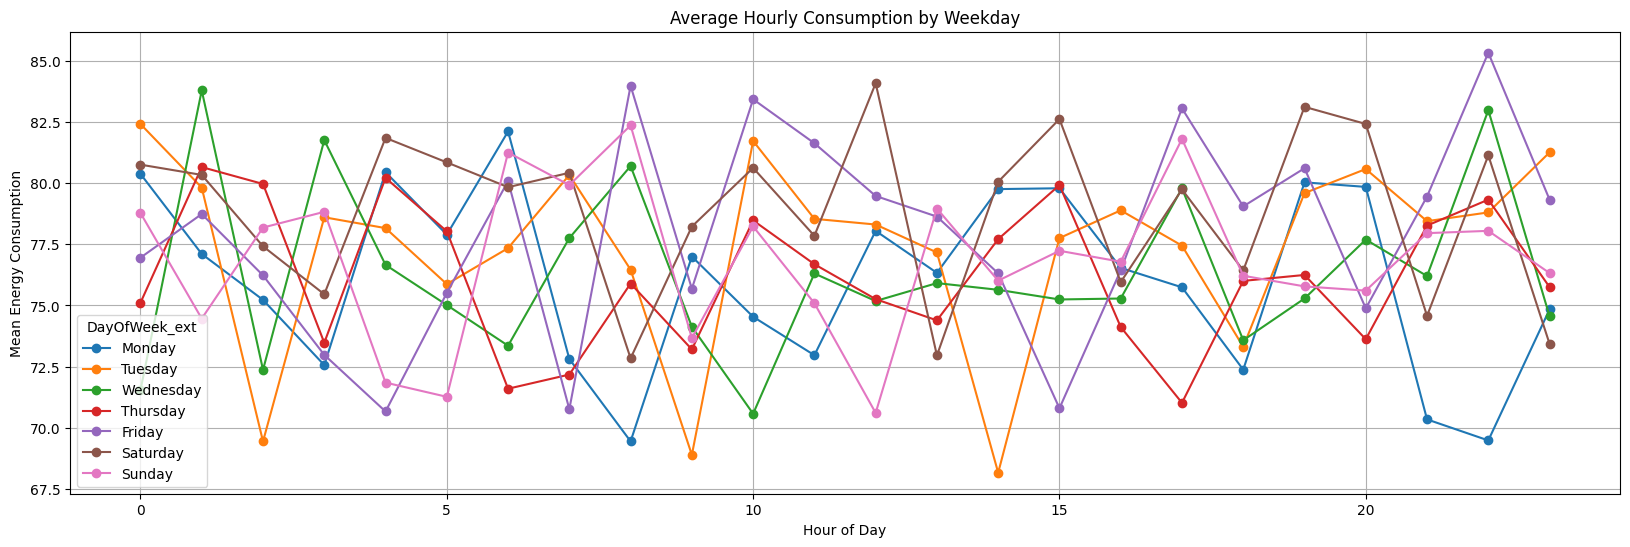

In [77]:
# Pivot table to average per day/hour combo
pivot = df_data.pivot_table(values='EnergyConsumption', index='Time', columns='DayOfWeek_ext', aggfunc='mean')

# Reorder days if needed
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot[days_order]

# Plot
pivot.plot(figsize=FIGSIZE_LONG, marker='o')
plt.title("Average Hourly Consumption by Weekday")
plt.ylabel("Mean Energy Consumption")
plt.xlabel("Hour of Day")
plt.grid(True)
plt.show()


## Daily Energy consumption
In these plots we focus on total evergy consumed per day and seek for data patterns in that scope

### Daily total Energy consumption during the month
- Generally, the are fluctuations in the daily consumption trend, but the average trends sounds constant. 
- The only exception to the above is the first few points in the data

Timestamp
2022-01-01    1841.057803
2022-01-02    1868.440913
2022-01-03    1738.618260
2022-01-04    1832.193743
2022-01-05    1841.714032
Freq: D, Name: EnergyConsumption, dtype: float64

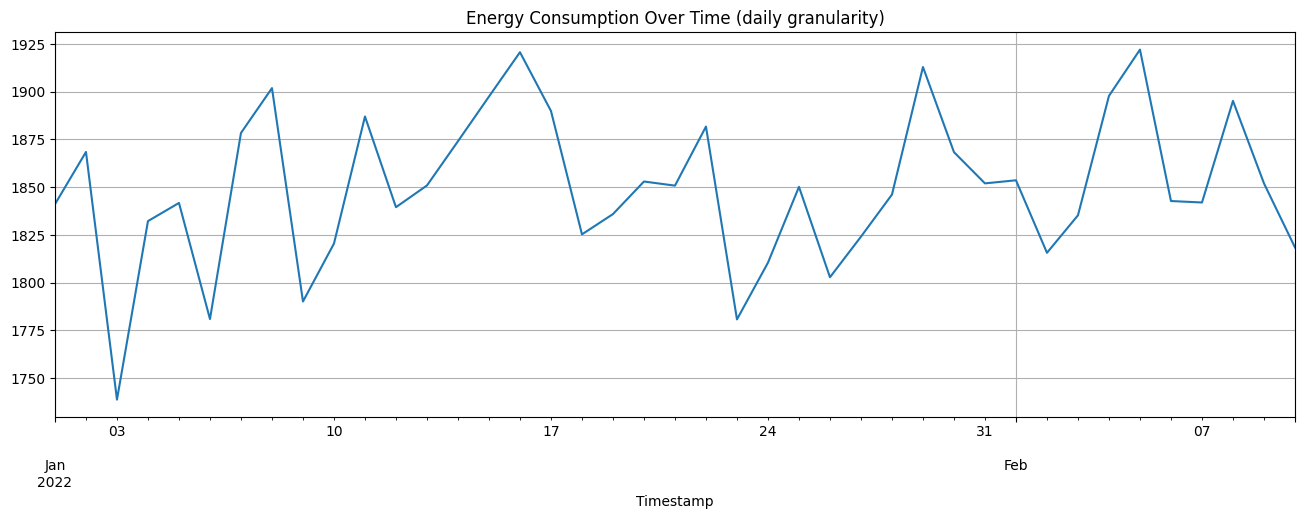

In [78]:
# Resample to daily frequency and sum
daily_energy = df_data_24h_complete['EnergyConsumption'].resample('D').sum()
daily_energy.plot(kind='line', figsize=FIGSIZE, title='Energy Consumption Over Time (daily granularity)', grid=True)
daily_energy.head()


### Consumption by day of week

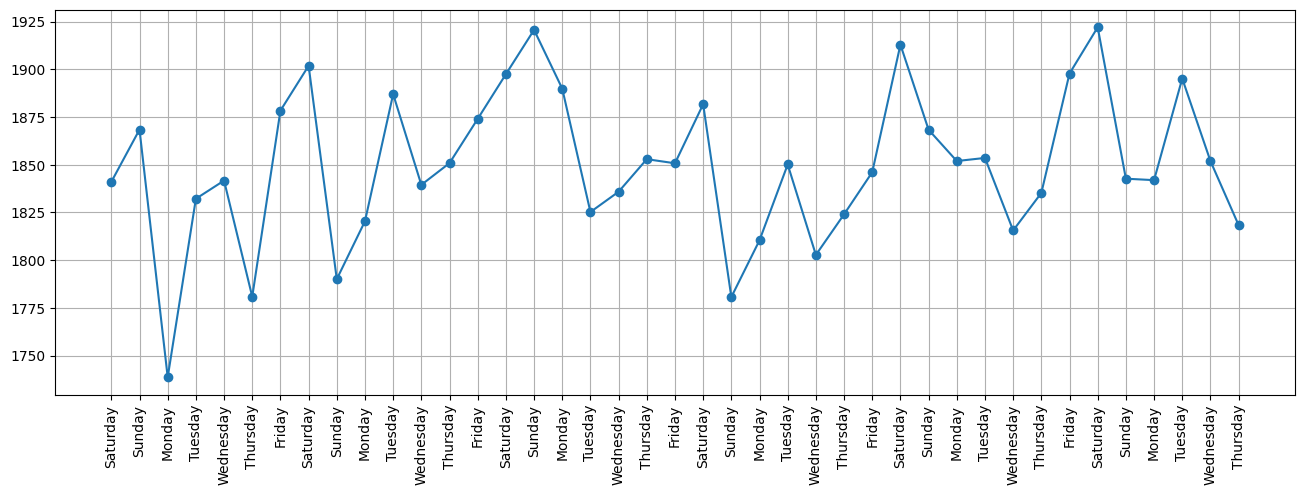

In [79]:
df_daily_energy = daily_energy.to_frame(name='DailyTotal')
df_daily_energy['DayOfWeek'] = df_daily_energy.index.day_name()
# df_daily_energy.plot(kind='line', y='DailyTotal', figsize=(10, 6), title='Energy Consumption Over Time (daily granularity)')
x = range(len(daily_energy))
plt.figure(figsize=FIGSIZE)
plt.plot(x, df_daily_energy.DailyTotal, marker='o', linestyle='-')
plt.xticks(x, df_daily_energy.DayOfWeek, rotation=90)
plt.grid(True)
plt.show()
# weekdays = daily.index.day_name()
# df_daily_energy.plot(kind='line', figsize=(10, 6), title='Energy Consumption Over Time (daily granularity)')
# plt.plot(df_daily_energy['DayOfWeek'], df_daily_energy['DailyTotal'])


### Smoothed daily consumption over time
There overal trend is not raising or falling over time, but data of more months is required to judge that over time.

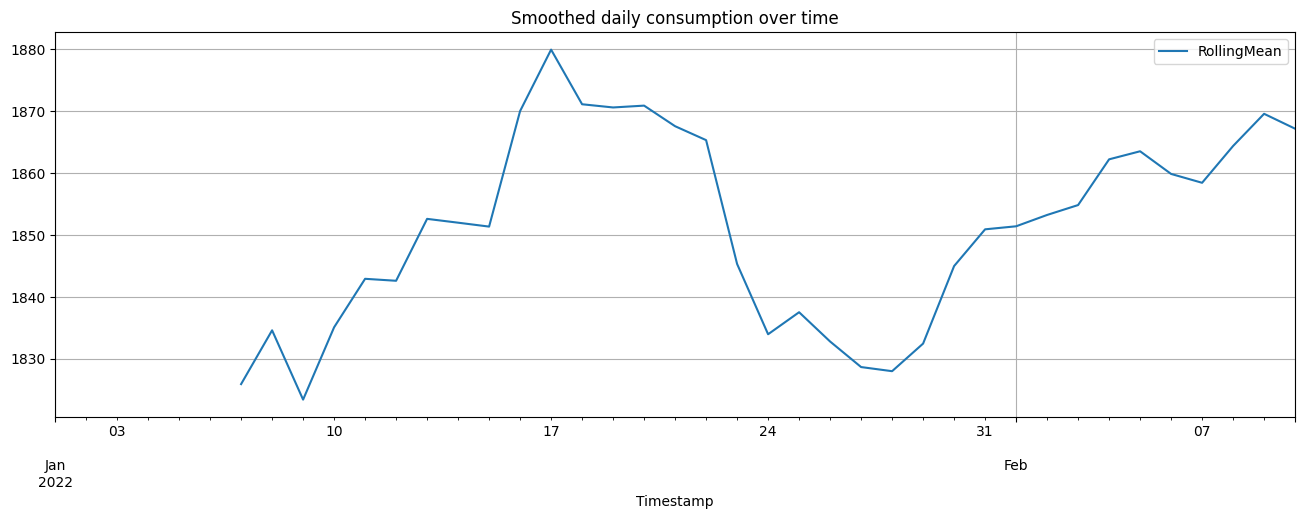

In [80]:
df_daily_energy['RollingMean'] = df_daily_energy['DailyTotal'].rolling(window=7).mean()
df_daily_energy.plot(kind='line', y='RollingMean', figsize=FIGSIZE, title='Smoothed daily consumption over time', grid=True)
plt.show()


### Consmption variation for each day of week:
- Here we observer larger variation on Sundays.
- Saturday seems to have most peeks in consumption.
- Some potential ouliers are spotted on Saturday and Monday. Than can explain the large drop on the first Monday of the timeseries.

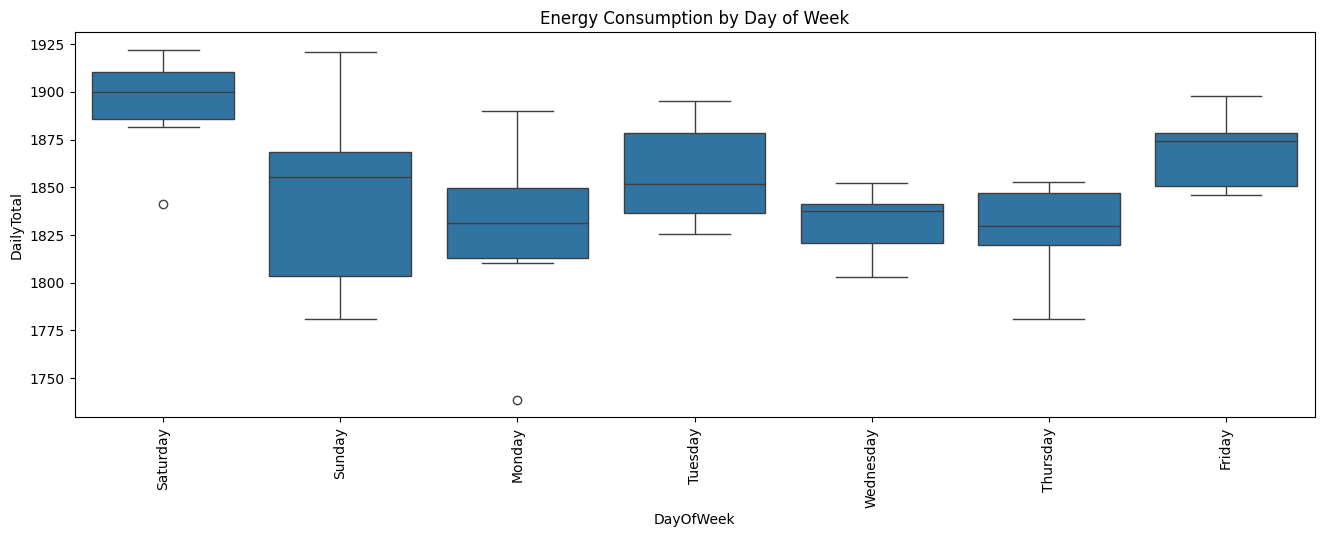

In [81]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(x='DayOfWeek', y='DailyTotal', data=df_daily_energy)
plt.xticks(rotation=90)
plt.title('Energy Consumption by Day of Week')
plt.show()

# Outlier removal
- The box plot of daily data shows the first Saturday and Monday data is belowe the distribution of those specific days of week.
- The first Monday's value is below the distribution of all days especifically.
- We remove the first 3 days of the dataset without negative impact on data size

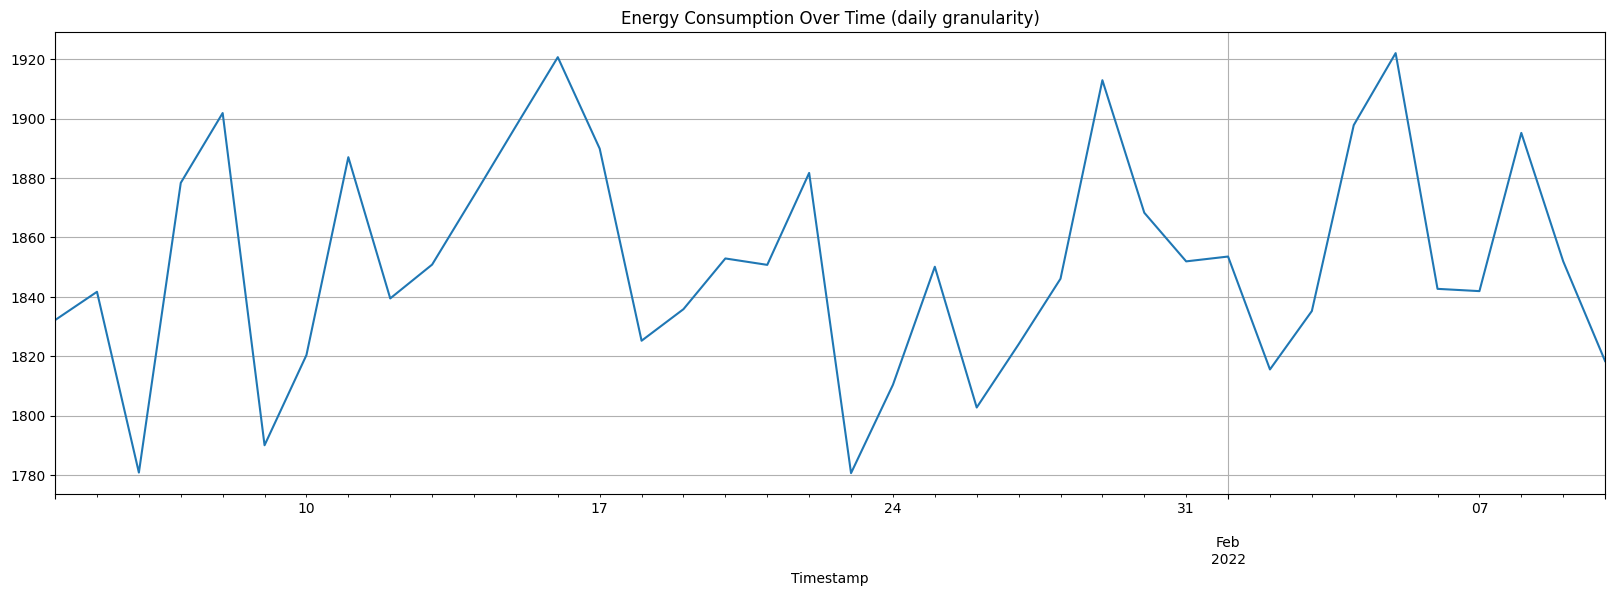

In [ ]:
df_data = df_data.loc['2022-01-04':]

df_data_24h_complete = df_data_24h_complete.loc['2022-01-04':]
daily_energy = df_data_24h_complete['EnergyConsumption'].resample('D').sum()
daily_energy.plot(kind='line', figsize=FIGSIZE_LONG, title='Energy Consumption Over Time (daily granularity)', grid=True)
df_data_24h_complete.head()
plt.show()

# Saving cleaned data

In [83]:
data_cleaned = {'df_data': df_data, 'df_data_24h_complete': df_data_24h_complete}
with open('../data/data_cleaned.pkl', 'wb') as f:
    pickle.dump(data_cleaned, f)

# Seasonal decomposition (trend, seasonality, residual)
Using Seasonal-Trend decomposition using Loess

## Hourly seasonality (period = 24)

In [84]:
def add_weekday_labels(fig):
    ''' This function adds weekday labels to the last plot.
    '''
    # Add weekday labels to the last plot
    ax = fig.axes[len(fig.axes) - 1]
    locs = ax.get_xticks()
    dates = [mdates.num2date(x) for x in locs]
    day_labels = [calendar.day_name[d.weekday()] for d in dates]
    secax = ax.secondary_xaxis('top')
    secax.set_xticks(locs)
    secax.set_xticklabels(day_labels, rotation=0, fontsize=8)


def seasonal_decompose_stl(df_data_window, col, period, figsize = FIGSIZE):
    ''' This function decomposes the data into trend, seasonal, and residual components using STL.
    '''
    # decomposition = seasonal_decompose(df_data_window[col], model='additive', period=24)
    stl = STL(df_data_window[col], period=period, robust=True)
    decomposition = stl.fit()

    resid = decomposition.resid.dropna()           # or STL.resid
    ratio_std = resid.std() / df_data_window[col].std()
    print(f"Residual σ / Original σ = {ratio_std:.2%}")
    explained_var = 1 - (resid.var() / df_data_window[col].var())
    print(f"Explained variance = {explained_var:.2%}")

    season = decomposition.seasonal
    seas_range = season.max() - season.min()
    resid_range = resid.max() - resid.min()
    ratio_range = resid_range/seas_range
    print(f"Residual range / Seasonal amplitude = {ratio_range:.2%}")

    fig = decomposition.plot()
    fig.set_size_inches(figsize)
    add_weekday_labels(fig)
    plt.tight_layout()
    for ax in fig.axes:
        ax.grid(True)
    plt.show()
    return ratio_std, ratio_range, explained_var


### Complete week

Residual σ / Original σ = 81.99%
Explained variance = 32.77%
Residual range / Seasonal amplitude = 123.92%


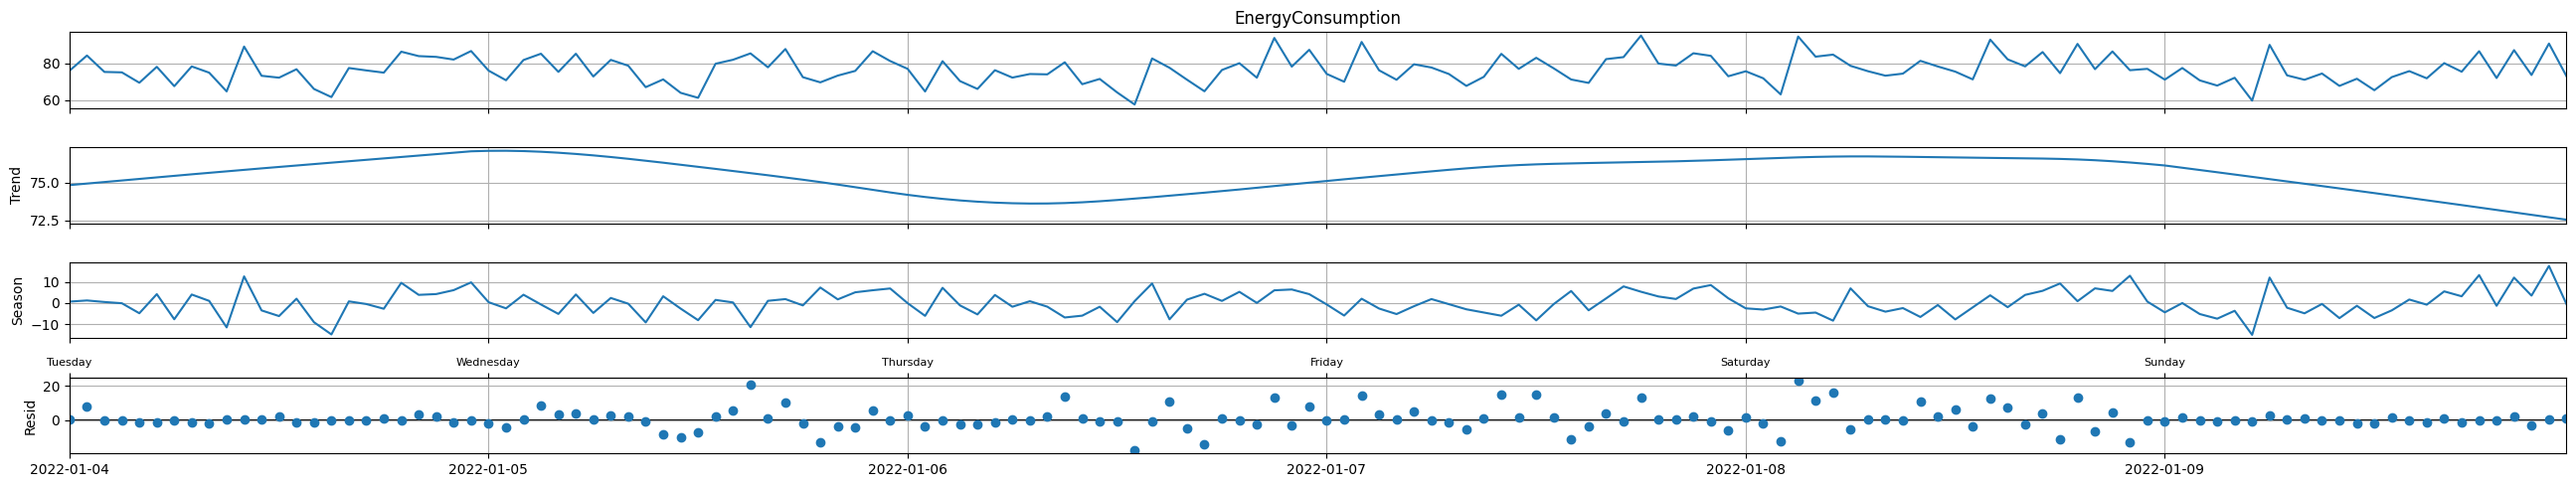

Residual σ / Original σ = 88.63%
Explained variance = 21.45%
Residual range / Seasonal amplitude = 119.64%


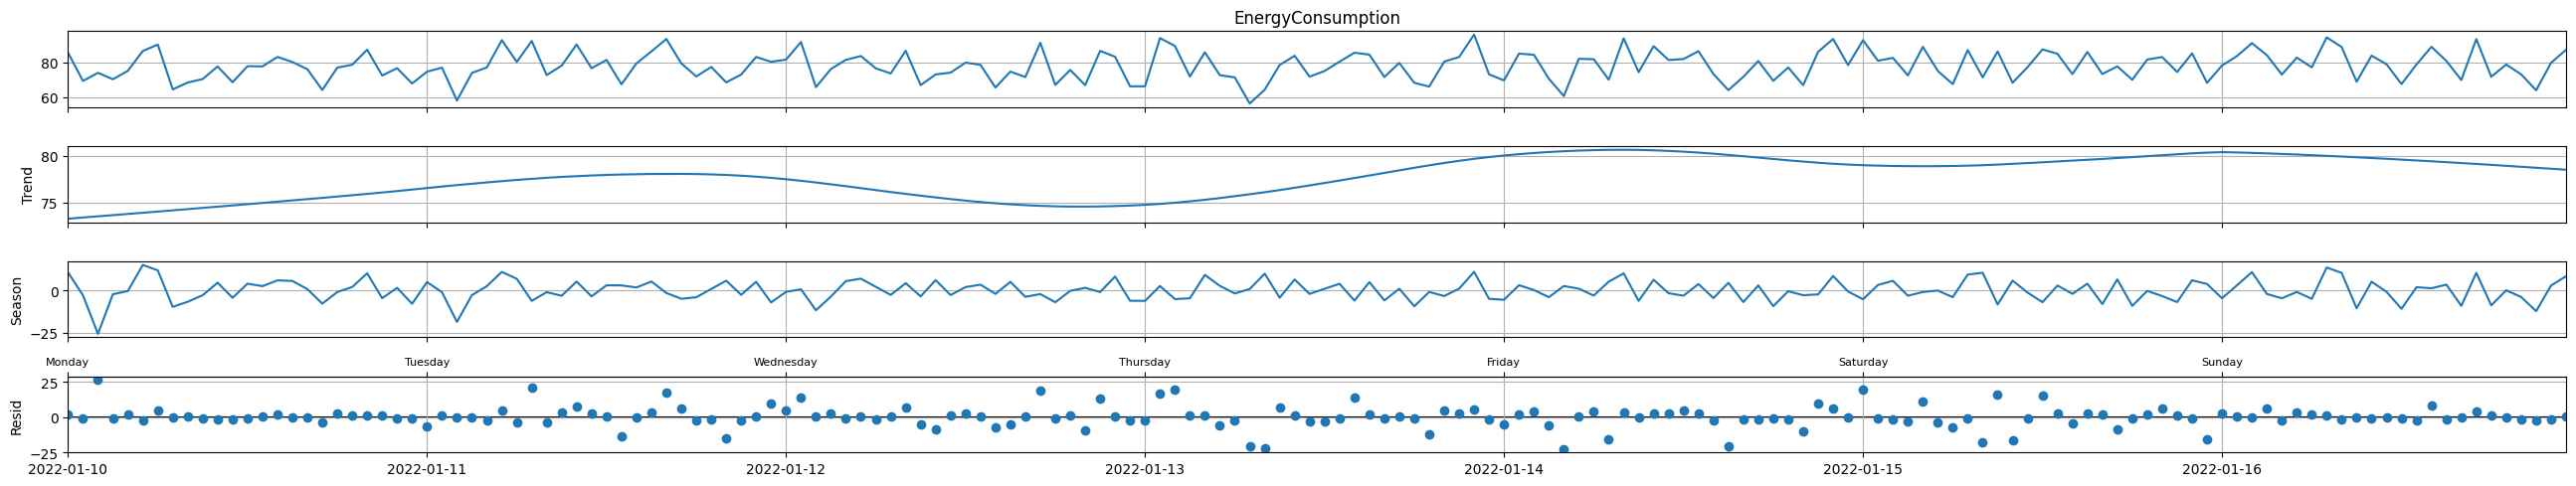

Residual σ / Original σ = 78.60%
Explained variance = 38.22%
Residual range / Seasonal amplitude = 181.52%


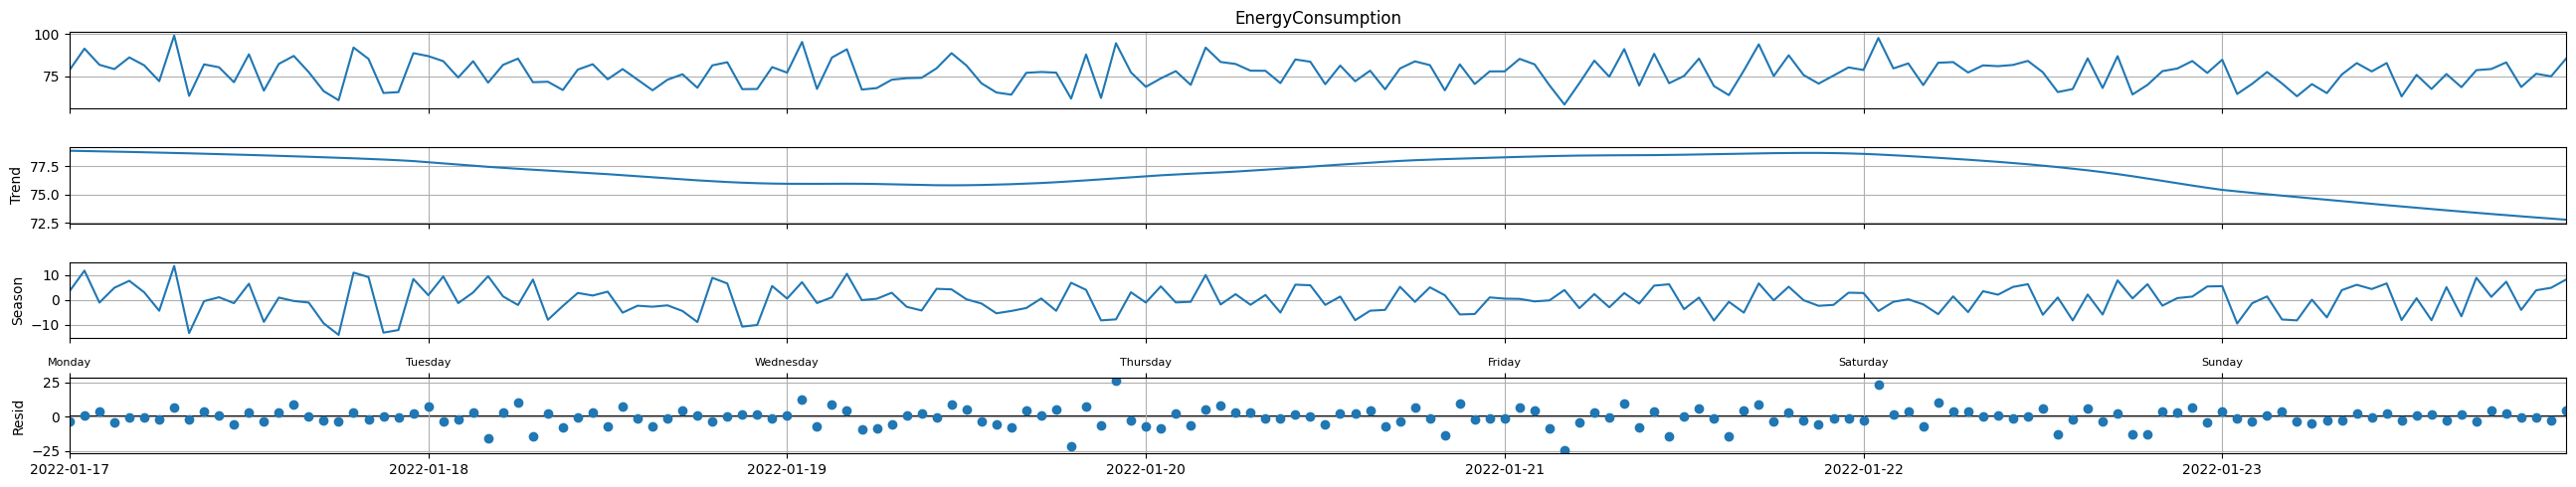

In [85]:
col = 'EnergyConsumption'
weeks = [
    ('2022-01-03', '2022-01-09'),
    ('2022-01-10', '2022-01-16'),
    ('2022-01-17', '2022-01-23'),
]

# Loop through each week and apply STL
for start_date, end_date in weeks:
    df_data_window = df_data.loc[start_date:end_date]
    seasonal_decompose_stl(df_data_window, col, period = 24, figsize = (26, 5))

## Daily Granularity (Day-of-Week) 

Residual σ / Original σ = 73.53%
Explained variance = 45.93%
Residual range / Seasonal amplitude = 140.53%


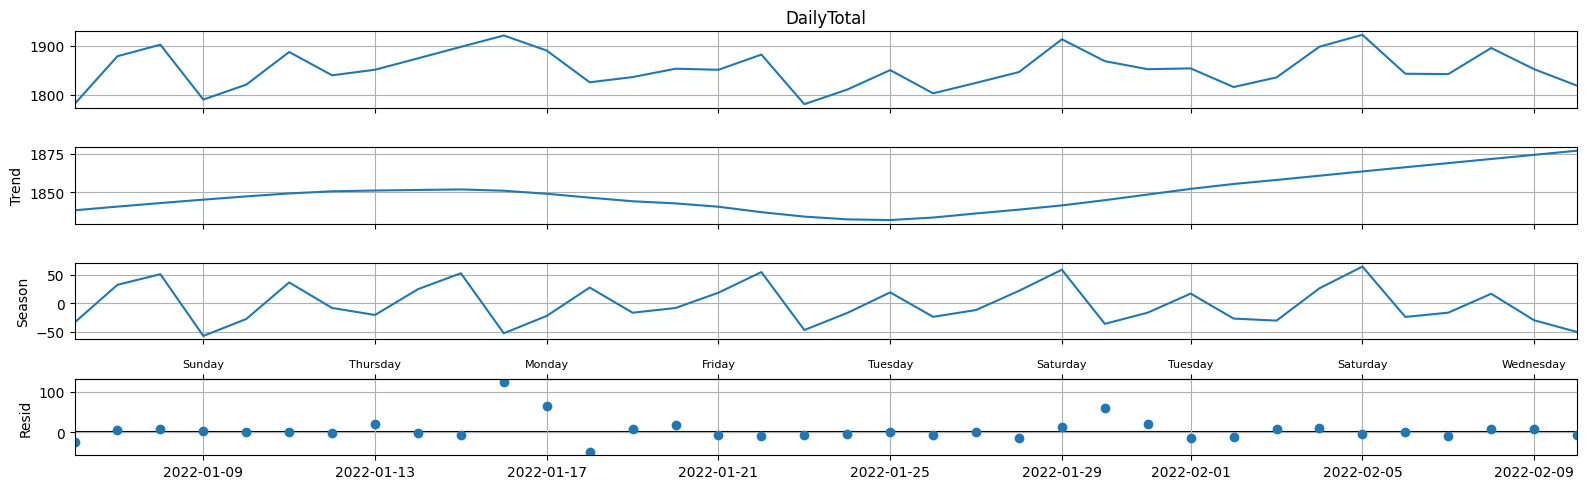

(np.float64(0.735308556165984),
 np.float64(1.4053005660280593),
 np.float64(0.459321327229096))

In [86]:
col = 'DailyTotal'
df_data_window = df_daily_energy.loc['2022-01-06':]
seasonal_decompose_stl(df_data_window, col, period = 7, figsize = FIGSIZE)

# Correlation matrix of numeric features
- The correlation matrix of numeric features show that Energy consumption has a high correlation with the Tempreture.
  - However, it's important to consider that we won't have the tempreture value for timestamps in the future!  
- The correlation matrix of daily energy consumption shows also a slight correlation with the Ren.Energy and square footage variables.

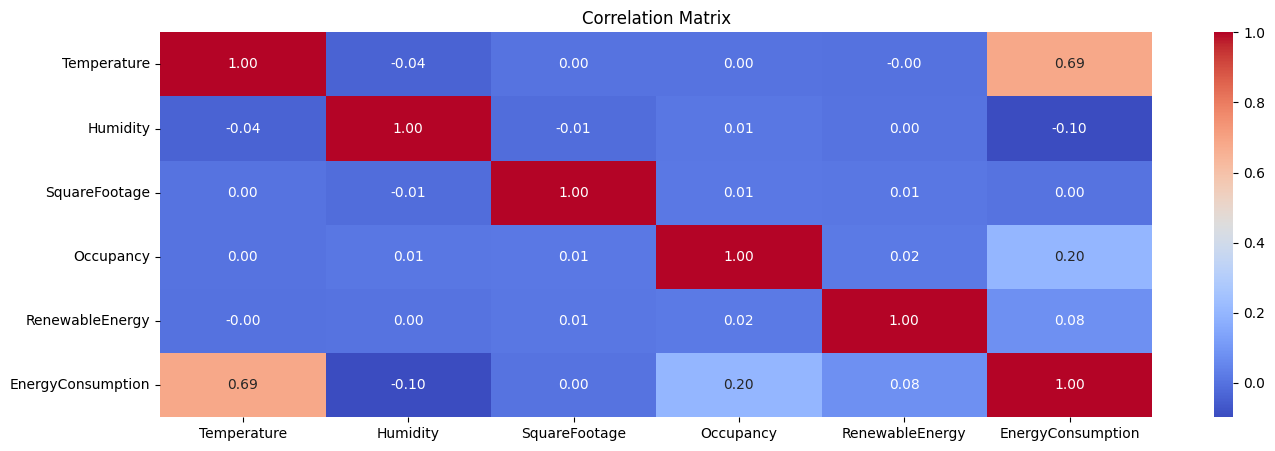

In [87]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=FIGSIZE)
correlation_matrix = df_data[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.title('Correlation Matrix')
plt.show()

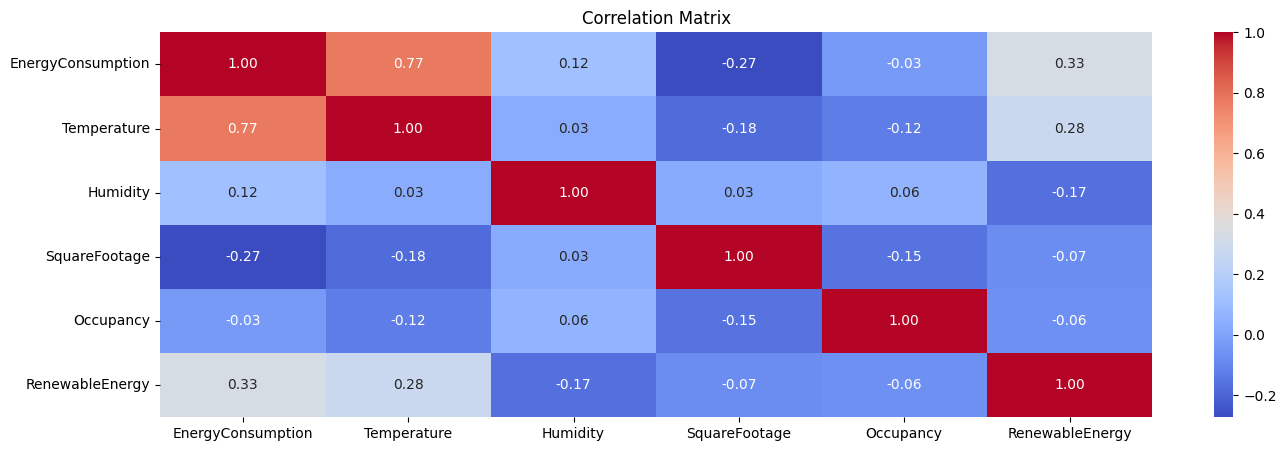

In [88]:
agg_dict = {
    'EnergyConsumption': 'sum',  # sum over day
    'Temperature': 'mean',
    'Humidity': 'mean',
    'SquareFootage': 'mean',
    'Occupancy': 'mean',    
    'RenewableEnergy': 'mean'
}
daily_energy_numeric = df_data_24h_complete.resample('D').agg(agg_dict)
# daily_energy.head()

plt.figure(figsize=FIGSIZE)
correlation_matrix = daily_energy_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.title('Correlation Matrix')
plt.show()

# ARIMA/SARIMA Readiness Check
- Check stationarity using Augmented Dickey-Fuller test
- Plot ACF and PACF for the energy consumption series
- If non-stationary, apply first-order differencing and recheck

## ADF Test — Check Stationarity

- ADF test shows that ADF Statistic for both daily and hourly data is below Critical Values at 1%, 5%, and 10%. Also p-value < 0.05.
- Therefore, daily and hourly energy consumption series are stationary, meaning, the mean and standard deviation are almost constant over time.
- This also supports the lack of observing any seasonal or structured changes or consistent trends in the data.

Actions: 
- There is no need for differencing (d=0) before using ARIMA

In [89]:
# Run ADF test
def ADF_check(data):
    result = adfuller(data)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    # return result

print('ADF test for hourly Energy Consumption')
ADF_check(df_data['EnergyConsumption'])

print('\n\nADF test for daily Energy Consumption')
ADF_check(daily_energy)


ADF test for hourly Energy Consumption
ADF Statistic: -30.134646578284105
p-value: 0.0
Critical Value (1%): -3.437423894618058
Critical Value (5%): -2.864662884591462
Critical Value (10%): -2.5684328157550835


ADF test for daily Energy Consumption
ADF Statistic: -5.0039063713243195
p-value: 2.1801455501038682e-05
Critical Value (1%): -3.626651907578875
Critical Value (5%): -2.9459512825788754
Critical Value (10%): -2.6116707716049383


## ACF and PACF for energy consumption serries
- ACF addresses the correlation of current value to lagged values of serries helping deciding q in ARIMA
- PACF focuses on the above correlatoin after removing shorter lags effects, helpting to determine p in ARIMA

Observations:
- ACF and PACF drops quickly and then oscillates slightly around 0
- No dominant lags stand out strongly, which might suggest no clear MA structure

Actions:
- plots suggest trying ARIMA with p,q with choices around 0,1,2


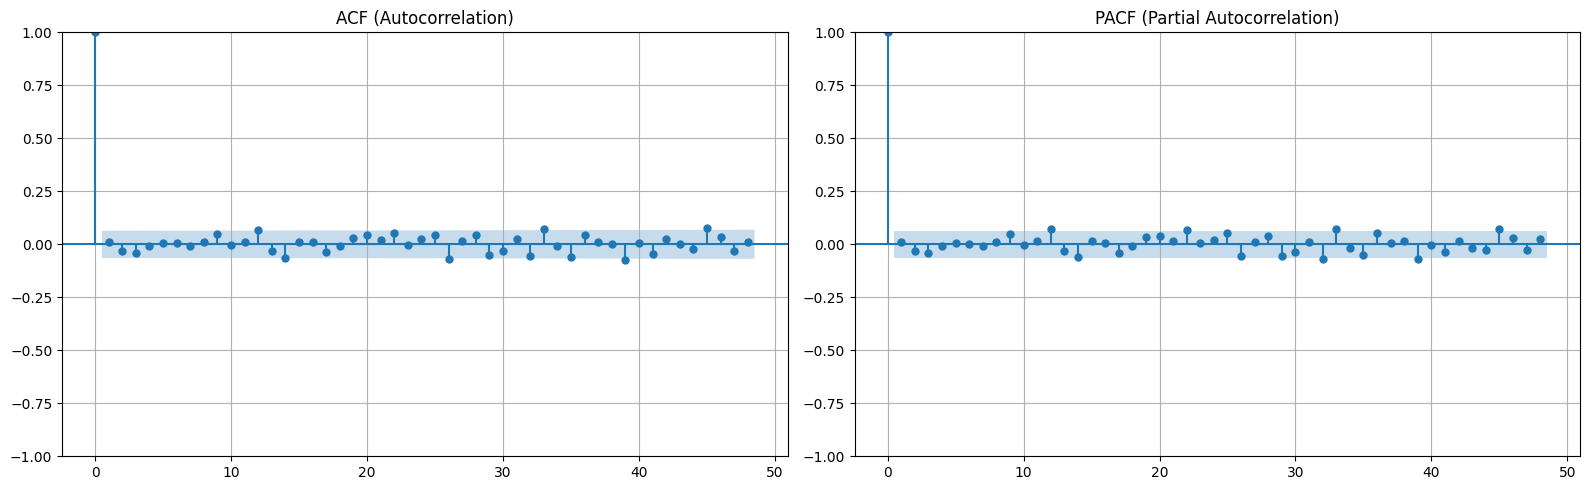

In [90]:
plt.figure(figsize= FIGSIZE)

plt.subplot(1, 2, 1)
plot_acf(df_data['EnergyConsumption'], lags=48, ax=plt.gca())
plt.title("ACF (Autocorrelation)")
plt.grid(True)

plt.subplot(1, 2, 2)
plot_pacf(df_data['EnergyConsumption'], lags=48, ax=plt.gca(), method='ywm')
plt.title("PACF (Partial Autocorrelation)")
plt.grid(True)
plt.tight_layout()
plt.show()


## ACF and PACF - daily consumption
- The ACF plot for daily consumption does not show any considerable drop in lags, hence no clear autocorrelation regarding the past samples in the data, and q = 0 or 1, 2.
- The PACF plot shows a drop after lag 12, that suggest the AR part to use p=12 order.

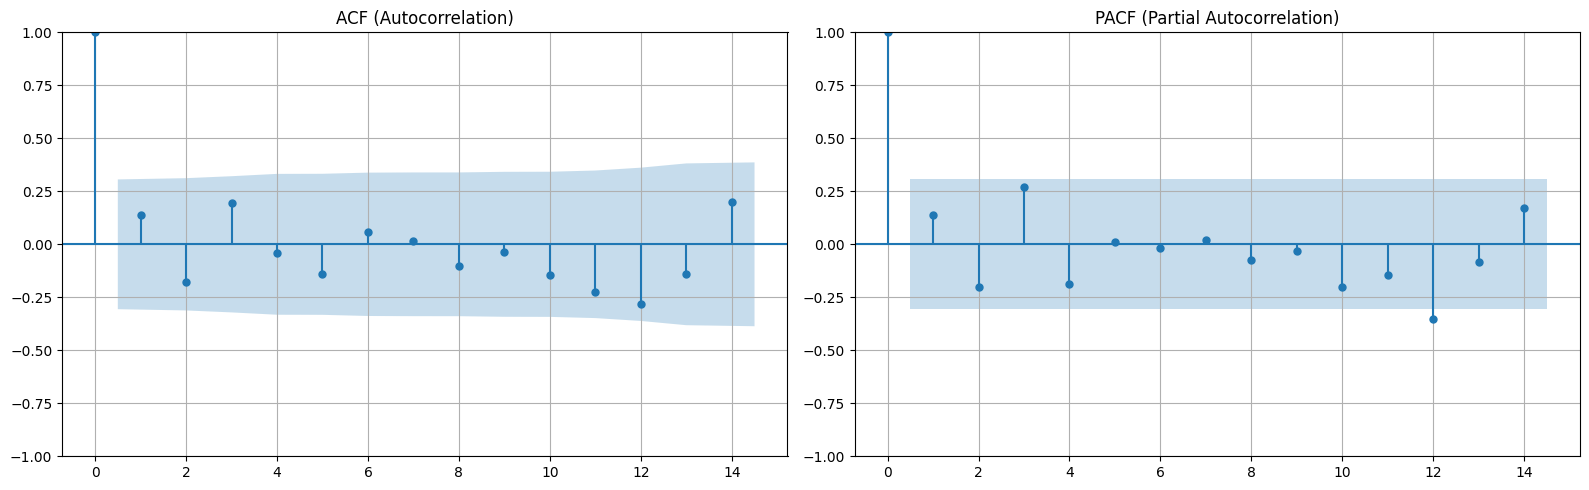

In [91]:
lags = 14
target_col = 'DailyTotal'

plt.figure(figsize= FIGSIZE)

plt.subplot(1, 2, 1)
plot_acf(df_daily_energy[target_col], lags=lags, ax=plt.gca())
plt.title("ACF (Autocorrelation)")
plt.grid(True)

plt.subplot(1, 2, 2)
plot_pacf(df_daily_energy[target_col], lags=lags, ax=plt.gca(), method='ywm')
plt.title("PACF (Partial Autocorrelation)")
plt.grid(True)
plt.tight_layout()
plt.show()
